In [78]:
import pandas as pd
import numpy as np 
from datetime import timedelta 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [79]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")

In [80]:
vessels_df = pd.read_csv('data/vessels.csv', sep = '|')

In [81]:
ports_df = pd.read_csv('data/ports.csv', sep = '|')

In [82]:
test_df = pd.read_csv('data/ais_test.csv', sep = ',')

## Preprocessing

In [83]:
train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])

timestamps = train_df[['time', 'vesselId']]

train_df['day_of_week'] = train_df['time'].dt.dayofweek
train_df['hour'] = train_df['time'].dt.hour
train_df['month'] = train_df['time'].dt.month

test_df['day_of_week'] = test_df['time'].dt.dayofweek
test_df['hour'] = test_df['time'].dt.hour
test_df['month'] = test_df['time'].dt.month

le_vesselid = LabelEncoder()
le_vesselid.fit(train_df['vesselId'])
train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])
test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])

train_df['navstat'] = pd.Categorical(train_df['navstat']).codes
train_df['portId'] = pd.Categorical(train_df['portId']).codes   


train_df['latitude_1'] = train_df['latitude'].shift(-1*24)
train_df['latitude_2'] = train_df['latitude'].shift(-2*24)
train_df['latitude_3'] = train_df['latitude'].shift(-3*24)
train_df['latitude_4'] = train_df['latitude'].shift(-4*24)
train_df['latitude_5'] = train_df['latitude'].shift(-5*24)

train_df['longitude_1'] = train_df['longitude'].shift(-1*24)
train_df['longitude_2'] = train_df['longitude'].shift(-2*24)
train_df['longitude_3'] = train_df['longitude'].shift(-3*24)
train_df['longitude_4'] = train_df['longitude'].shift(-4*24)
train_df['longitude_5'] = train_df['longitude'].shift(-5*24)

train_df = train_df.dropna()
train_df = train_df.drop(columns = ['etaRaw','time'])

In [84]:
display(train_df)

,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,day_of_week,...,latitude_1,latitude_2,latitude_3,latitude_4,latitude_5,longitude_1,longitude_2,longitude_3,longitude_4,longitude_5
0,284.0,0.7,0,88,0,-34.74370,-57.85130,50,40,0,...,53.33566,53.57547,-27.37935,34.78171,51.89047,7.20093,8.55260,153.16482,140.45506,4.45850
1,109.6,0.0,-6,347,1,8.89440,-79.47939,189,674,0,...,45.55133,51.26160,38.51052,50.77825,38.76154,13.73575,4.23430,-8.86518,0.96818,-74.76938
2,111.0,11.0,0,112,0,39.19065,-76.47567,432,353,0,...,51.88025,43.57881,51.29663,1.27443,39.16120,4.42177,10.30563,3.24152,104.20983,-75.25469
3,96.4,0.0,0,142,1,-34.41189,151.02067,110,18,0,...,53.92160,31.96719,1.27223,51.79121,50.63674,7.80515,-80.47254,103.88870,2.22874,-2.78456
4,214.0,19.7,0,215,0,35.88379,-5.91636,356,605,0,...,55.33025,29.85957,38.15504,53.64703,41.62135,14.57044,-93.94005,13.39125,6.13395,141.23204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521940,24.7,0.0,0,214,5,14.81694,120.29625,623,269,1,...,54.84826,40.78302,40.55500,55.45904,52.19131,12.53570,29.03070,18.51833,14.85964,-5.82223
1521941,246.8,0.0,0,61,5,42.23317,-8.74787,584,322,1,...,-32.04002,18.27172,37.95934,51.13100,38.96142,115.75076,-103.92891,23.60570,-5.13567,-12.00502
1521942,264.7,0.0,-1,39,5,-32.04416,115.75027,71,9,1,...,16.15520,1.17835,59.89167,30.31615,49.71372,-62.04040,103.75237,21.54685,-12.94690,-5.22042
1521943,127.0,0.0,0,180,5,1.26895,103.85177,425,292,1,...,54.68123,50.81877,50.00852,38.13006,38.27895,-0.76436,1.02754,-2.22267,-9.70407,10.78280


In [152]:
X = train_df[['cog','sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude', 'vesselId', 'portId', 'day_of_week', 'hour', 'month']]
y = train_df[['latitude_1', 'latitude_2', 'latitude_3', 'latitude_4', 'latitude_5', 'longitude_1','longitude_2','longitude_3','longitude_4','longitude_5']]

N = int(len(X)*0.8)
X_train = X[:N]
y_train = y[:N]

X_test = X[N:]
y_test = y[N:]

In [85]:

model = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.01, max_depth = 2)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [86]:
y_pred = model.predict(X_test)

In [153]:
timestamps['ordinal'] = timestamps['time'].apply(lambda x: x.toordinal())

/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_24261/1064027264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vessel_df['latitude_1'] = vessel_df['latitude'].shift(-1)
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_24261/1064027264.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vessel_df['latitude_2'] = vessel_df['latitude'].shift(-2)
/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_24261/1064027264.py:10: SettingWithCopyWarning: 
A value is trying to be set on a

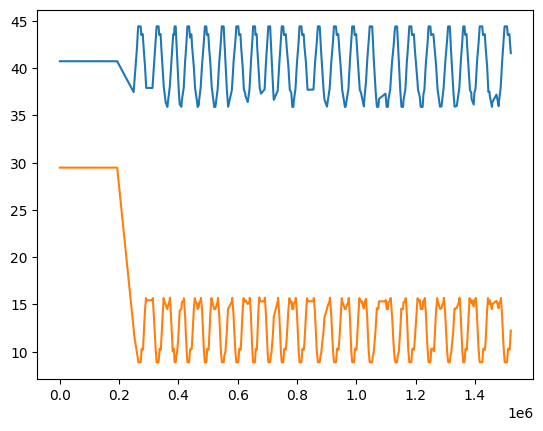

In [235]:
import matplotlib.pyplot as plt
n = 6

features = ['cog','sog', 'rot', 'heading', 'navstat', 'latitude', 'longitude', 'vesselId', 'portId', 'day_of_week', 'hour', 'month']
targets = ['latitude_1', 'latitude_2', 'latitude_3', 'latitude_4', 'latitude_5', 'longitude_1','longitude_2','longitude_3','longitude_4','longitude_5']

vessel_df = train_df[train_df['vesselId'] == train_df['vesselId'][n]]
vessel_df['latitude_1'] = vessel_df['latitude'].shift(-1)
vessel_df['latitude_2'] = vessel_df['latitude'].shift(-2)
vessel_df['latitude_3'] = vessel_df['latitude'].shift(-3)
vessel_df['latitude_4'] = vessel_df['latitude'].shift(-4)
vessel_df['latitude_5'] = vessel_df['latitude'].shift(-5)


vessel_df['longitude_1'] = vessel_df['longitude'].shift(-1)
vessel_df['longitude_2'] = vessel_df['longitude'].shift(-2)
vessel_df['longitude_3'] = vessel_df['longitude'].shift(-3)
vessel_df['longitude_4'] = vessel_df['longitude'].shift(-4)
vessel_df['longitude_5'] = vessel_df['longitude'].shift(-5)

vessel_df = vessel_df.dropna()

X_vessel = vessel_df[features]
y_vessel = vessel_df[targets]

plt.plot(vessel_df['latitude'])
plt.plot(vessel_df['longitude'])

In [236]:
N = int(len(X_vessel)*0.8)

X_vessel_train = X_vessel[:N]
y_vessel_train = y_vessel[:N]

X_vessel_test = X_vessel[N:]
y_vessel_test = y_vessel[N:]

In [237]:
model_vessel = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.01, max_depth = 5)
model_vessel.fit(X_vessel_train, y_vessel_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [238]:
y_vessel_predict = model_vessel.predict(X_vessel_test)

975
3898


,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,day_of_week,hour,month
1520285,135.1,19.8,0,135,0,41.86733,11.84678,608,130,1,20,5
1520435,133.8,19.8,0,134,0,41.78984,11.95210,608,130,1,21,5
1520662,133.8,19.7,0,135,0,41.71084,12.05997,608,130,1,21,5
1520835,134.7,19.7,0,134,0,41.65290,12.13841,608,130,1,21,5
1521001,135.5,19.8,0,135,0,41.57433,12.24291,608,130,1,22,5


,cog,sog,rot,heading,navstat,latitude,longitude,vesselId,portId,day_of_week,hour,month
1235263,310.2,21.1,0,311,0,40.82006,13.55598,608,131,6,14,4
1235468,305.4,20.6,0,304,0,40.89269,13.42429,608,131,6,14,4
1235628,305.6,20.7,0,304,0,40.96133,13.29724,608,131,6,15,4
1235820,306.6,20.6,0,306,0,41.03016,13.17447,608,131,6,15,4
1236035,304.2,20.7,0,304,0,41.10023,13.04474,608,131,6,15,4


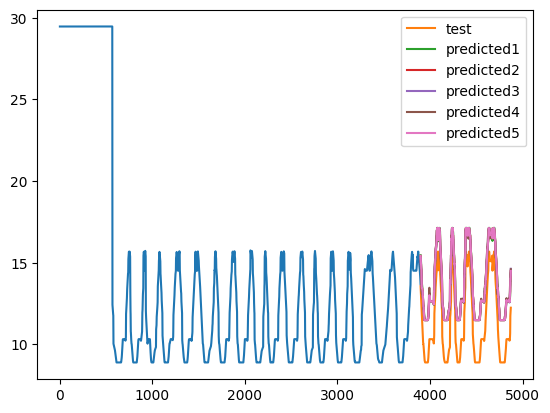

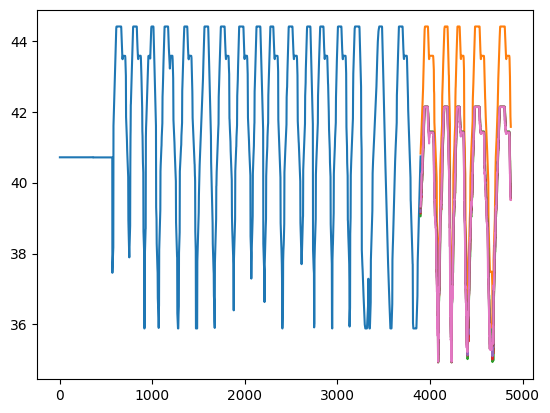

In [239]:
print(len(y_vessel_predict[:,0]))
print(len(X_vessel_train['latitude']))

display(X_vessel_test.tail())
display(X_vessel_test.head())

plt.plot(np.linspace(0, len(X_vessel_train['longitude']), len(X_vessel_train['longitude'])), X_vessel_train['longitude'])
plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), X_vessel_test['longitude'] , label = 'test')
plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict[:,5], label = 'predicted1')
plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict[:,6], label = 'predicted2')
plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict[:,7], label = 'predicted3')
plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict[:,8], label = 'predicted4')
plt.plot(np.linspace(len(X_vessel_train['longitude']), len(X_vessel_test['longitude']) + len(X_vessel_train['longitude']) , len(X_vessel_test['longitude'])), y_vessel_predict[:,6], label = 'predicted5')
plt.legend()

plt.figure()

plt.plot(np.linspace(0, len(X_vessel_train['latitude']), len(X_vessel_train['latitude'])), X_vessel_train['latitude'])
plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), X_vessel_test['latitude'] , label = 'test')
plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict[:,0], label = 'predicted1')
plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict[:,1], label = 'predicted2')
plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict[:,2], label = 'predicted3')
plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict[:,3], label = 'predicted4')
plt.plot(np.linspace(len(X_vessel_train['latitude']), len(X_vessel_test['latitude']) + len(X_vessel_train['latitude']) , len(X_vessel_test['latitude'])), y_vessel_predict[:,4], label = 'predicted5')


ValueError: x and y must have same first dimension, but have shapes (0,) and (1216,)

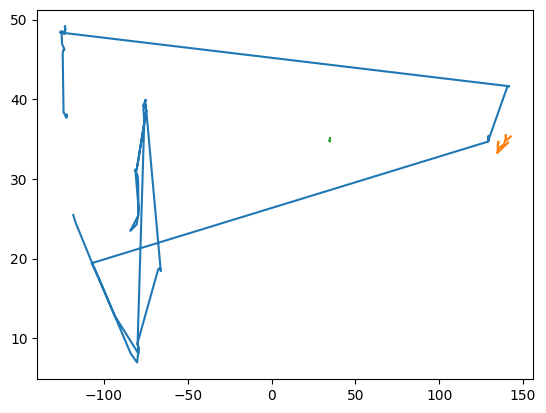

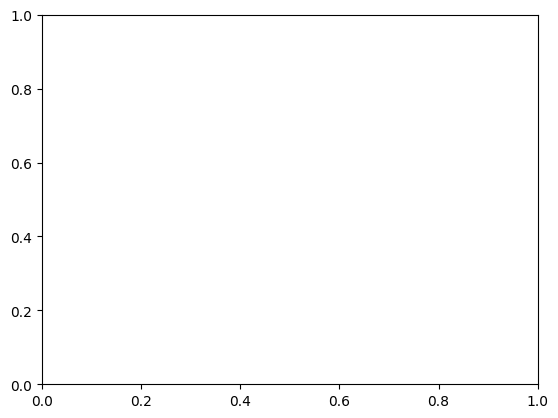

In [98]:
plt.figure()

plt.plot(data_vessel_train['longitude'], data_vessel_train['latitude'])
plt.plot(data_vessel_test['longitude'], data_vessel_test['latitude'])
plt.plot(data_vessel_pred[:,0], data_vessel_pred[:,1])


plt.figure()
plt.plot(timestamps[timestamps['vesselId'] == X_train['vesselId'].iloc[n]][:len(data_vessel_train['latitude'])]['ordinal'], data_vessel_train['latitude'])
plt.plot(timestamps[timestamps['vesselId'] == X_train['vesselId'].iloc[n]][:len(data_vessel_train['latitude'])]['ordinal'], data_vessel_train['latitude'])

plt.plot(timestamps[timestamps['vesselId'] == X_train['vesselId'].iloc[n]][len(data_vessel_test['longitude']):]['ordinal'], data_vessel_test['longitude'])
plt.plot(timestamps[timestamps['vesselId'] == X_train['vesselId'].iloc[n]][len(data_vessel_test['longitude']):]['ordinal'], data_vessel_test['longitude'])



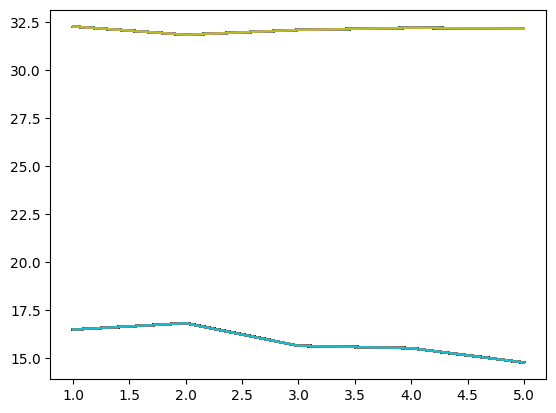

In [13]:

for i in range(10000):
    plt.plot(np.linspace(1,5, 5), y_pred[0,:5])
    plt.plot(np.linspace(1,5, 5), y_pred[0,5:])
